In [80]:
self_energy_intial_value = 0
chemical_potential = 0

In [81]:
def rho(epsilon):
    return (1/(2*np.pi)) * np.sqrt(4 - epsilon**2)


In [82]:
import numpy as np
from scipy.interpolate import interp1d
#from matplotlib import pyplot as plt
from scipy import integrate

In [83]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import irbasis3

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
})

In [84]:
from scipy.integrate import quad
assert np.abs(quad(rho, -2, 2)[0] - 1) < 1e-9 # Check rule

In [85]:
D = 2
temp = 0.1/D
beta = 1/temp
wmax = 10.0 * D
lambda_ = beta * wmax
eps = 1e-9

wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(K, statistics="F", beta=beta, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = irbasis3.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = irbasis3.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  11.408396757532548
cond (matsu):  17.755472692037568


In [86]:
print(smpl_matsu.sampling_points)

[-879 -837 -795 -339 -201 -137 -101  -75  -59  -45  -35  -29  -23  -19
  -15  -13  -11   -9   -7   -5   -3   -1    1    3    5    7    9   11
   13   15   19   23   29   35   45   59   75  101  137  201  339  795
  837  879]


In [87]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

class IPTSolver:
    def __init__(self, U, basis, rho_omega, omega_range, deg_leggauss=1000):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.basis = basis
        self.beta = basis.beta
        self.rho_omega = rho_omega

        x_, w_ = leggauss(deg_leggauss)
        self._quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])

        self._smpl_matsu = irbasis3.MatsubaraSampling(basis)
        self._smpl_tau = irbasis3.TauSampling(basis)

    def gloc_iv(self, sigma_iv):
        """
        Compute G_loc(iv) from Sigma_iv

        G_loc(iv) \simeq \sum_q w_q rho(x_q)/(iv - w_q - \Sigma(iv))
        """
        quad_points = self._quad_rule[0]
        quad_weight = self._quad_rule[1]
        #print(quad_points, quad_weight)
        #松原周波数
        iv = 1j * self._smpl_matsu.sampling_points * np.pi/self.beta
        r = np.einsum('q,q,wq->w',
            quad_weight,
            self.rho_omega(quad_points),
            1/((iv-sigma_iv)[:,None] - quad_points[None,:]),
            optimize=True
        )
        return r
    
    def g0_iv(self, gloc, sigma_iw):
        """
        Compute \mathcal{G}(iv) from G_loc(iv) and Sigma(iv)
        """
        return 1/(1/gloc + sigma_iw)

    def sigma_iv(self, g0_iv):
        """
        Compute Sigma(tau) from \mathcal{G}(iv)
        """
        g0_IR = self._smpl_matsu.fit(g0_iv, axis=0)
        g0_tau = self._smpl_tau.evaluate(g0_IR)
        sigma_tau = (self.U**2) * (g0_tau**2) * g0_tau[::-1]
        sigma_IR = self._smpl_tau.fit(sigma_tau)
        return self._smpl_matsu.evaluate(sigma_IR, axis=0)
    
    def new_sigma_iv(self, sigma_iv):
        gloc_iv = self.gloc_iv(sigma_iv)
        g0_iv = self.g0_iv(gloc_iv, sigma_iv)
        r = self.sigma_iv(g0_iv)
        return r

In [88]:
niter = 10000
mixing = 0.1

#U_1 = np.linspace(12/D,13/D,5)
#U_1 = 2*np.array([1e-3/D, 1/D, 2/D, 3/D, 4/D, 5/D, 6/D, 6.5/D])
U_1 = 2*np.linspace(5/D, 6.5/D, 20)

def normalize_factor(u, sigma_ini=None) :
    # Initialize solver
    solver = IPTSolver(u, basis, rho, (-2,2))

    if sigma_ini is None:
        sigma_ini = np.zeros_like(solver._smpl_matsu.sampling_points.size, dtype=np.complex128)

    sigma_iv = sigma_ini.copy()

    for iter in range(niter):
        new_sigma_iv = solver.new_sigma_iv(sigma_iv)
        rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
        #print(iter, rdiff)
        if rdiff < 1e-5:
            break
        sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv

    center = int(len(sigma_iv.imag)/2)
    print("DEBUG A:",sigma_iv.imag[center])
    print("DEBUG B:",sigma_iv.imag[center-1])
    print("DEBUG C:",solver._smpl_matsu.sampling_points[center])
    print("DEBUG D:",solver._smpl_matsu.sampling_points[center-1])
    z = 1/(1-(sigma_iv.imag[center] - sigma_iv.imag[center-1])/(solver._smpl_matsu.sampling_points[center] - solver._smpl_matsu.sampling_points[center-1]))
    print("DEBUG E:",z)

    return z, sigma_iv

Z = []
Sigma_U = []
for u in U_1:
    print("U=",u)
    zz, s_u = normalize_factor(u, Sigma_U[-1] if len(Sigma_U) > 0 else None)
    Sigma_U.append(s_u)
    #print(Sigma_U)
    if abs(zz) > 1e-10:
        Z.append(zz)

    else:
        break



U= 5.0


/var/folders/sj/r6r7g8b92sn7bsfckjxgg8lr0000gn/T/ipykernel_40761/3742850191.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()


DEBUG A: -0.6930120950724621
DEBUG B: 0.6930120950724616
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.5906632344272764
U= 5.078947368421052
DEBUG A: -0.747885247468118
DEBUG B: 0.7478852474681178
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.572119938336078
U= 5.157894736842105
DEBUG A: -0.8097629269732644
DEBUG B: 0.8097629269732627
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.5525585617296566
U= 5.2368421052631575
DEBUG A: -0.8803029439950186
DEBUG B: 0.880302943995018
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.5318291944357288
U= 5.315789473684211
DEBUG A: -0.9618597749242869
DEBUG B: 0.9618597749242849
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.5097204258844611
U= 5.394736842105263
DEBUG A: -1.0579627966962009
DEBUG B: 1.0579627966961982
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.4859174333012114
U= 5.473684210526316
DEBUG A: -1.1743730227026552
DEBUG B: 1.1743730227026448
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.4599026889861998
U= 5.552631578947368
DEBUG A: -1.321721960374943
DEBUG B: 1.3217219603748498
DEBUG C: 1
DEBUG D: -1
DEBUG E: 0.430714795

In [89]:
Z

[0.5906632344272764,
 0.572119938336078,
 0.5525585617296566,
 0.5318291944357288,
 0.5097204258844611,
 0.4859174333012114,
 0.4599026889861998,
 0.43071479577103483,
 0.3961399116892718,
 0.34757426599492586,
 0.03214016908001929,
 0.030481252557794623,
 0.028988902827114995,
 0.02763617768573706,
 0.02640214307390144,
 0.025270255983809574,
 0.024227185470060843,
 0.02326206621306231,
 0.022365801230765564,
 0.021530800093991977]

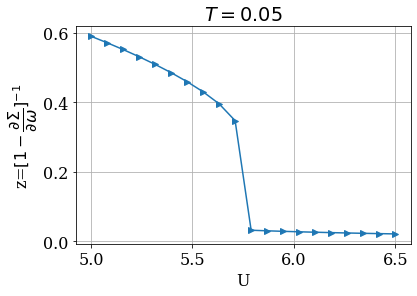

In [90]:
plt.plot(U_1,Z, marker=">")
#plt.xticks(np.arange(0,7,1))
plt.xlabel("U")
plt.ylabel("z=$[1-\dfrac{\partial \Sigma}{\partial \omega}]^{-1}$")
#plt.ylim(0,1.1)
plt.title("$T={0}$".format(1/beta))
plt.grid()

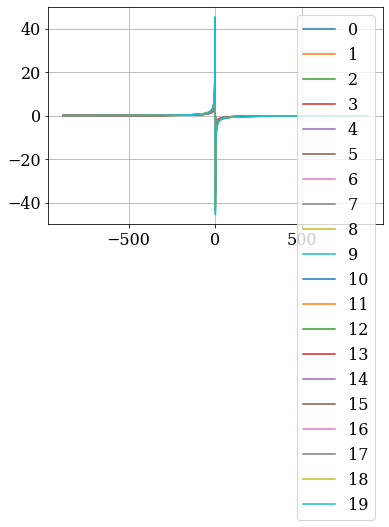

In [91]:
for i in range(len(Sigma_U)):
    plt.plot(smpl_matsu.sampling_points, Sigma_U[i].imag, label=str(i))
plt.grid()
plt.legend()

In [92]:
#plt.plot(solver._quad_rule[0],solver._quad_rule[1])

In [93]:
# lll = leggauss(10000)
# plt.plot(lll[0],lll[1])

In [94]:

# sigma_iv = np.zeros_like(
#     solver._smpl_matsu.sampling_points.size, dtype=np.complex128)

In [95]:
# # Gloc_iv
# gloc_iv = solver.gloc_iv(sigma_iv)
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     gloc_iv.real,label = "Re $G_{local}(i\omega_n)$"
# )
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     gloc_iv.imag, label = "Im $G_{local}(i\omega_n)$"
# )

# plt.xlabel("$\omega_n$")
# plt.legend()

In [96]:
# # Gloc_iv
# g0_iv = solver.g0_iv(gloc_iv, sigma_iv)
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     g0_iv.real ,label = "Re $G_{0}(i\omega_n)$"
# )
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     g0_iv.imag,  label = "Im $G_{0}(i\omega_n)$"
# )
# plt.xlabel("$\omega_n$")
# plt.legend()


In [97]:
# for iter in range(niter):
#     new_sigma_iv = solver.new_sigma_iv(sigma_iv)
#     rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
#     print(iter, rdiff)
#     if rdiff < 1e-10:
#         break
#     sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv


In [98]:
# fig = plt.figure(figsize=(12,5))
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     sigma_iv.imag,
#     marker="x"
# )
# plt.xticks(np.arange(min(solver._smpl_matsu.sampling_points),max(solver._smpl_matsu.sampling_points),20))
# plt.grid()

In [99]:
# center = int(len(sigma_iv.imag)/2)
# print(center)
# (sigma_iv.imag[center] - sigma_iv.imag[center-1])/(solver._smpl_matsu.sampling_points[center] - solver._smpl_matsu.sampling_points[center-1])


In [100]:
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     sigma_iv.real,
#     marker="x"
# )
# plt.ylim(-0.1,0.1)

In [101]:
#max(solver._smpl_matsu.sampling_points)

In [102]:
# plt.rcParams.update({
#     #"text.usetex": True,
#     "font.family": "serif",
#     "font.size": 16
# })

In [103]:
# from scipy.special import eval_legendre

# nx = 1000
# nvec = np.arange(5)
# xvec = np.linspace(-1, 1, nx)
# legval = eval_legendre(nvec[None,:], xvec[:,None])
# print(legval.shape)

In [104]:
# for n in nvec:
#     plt.plot(xvec, legval[:,n], label=r'$n='+str(n)+r'$')
# plt.grid()
# plt.legend(loc='best', frameon=False)
# plt.xlabel(r'$x$')
# plt.ylabel(r'$P_n(x)$')
# plt.tight_layout()
# plt.savefig('legendre_polynomials.pdf', transparent=True)
# ;
# ''